### Introduction

This notebook is associated with the publication ["Neural decoding from stereotactic EEG: accounting for electrode variability across subjects](https://gmentz.github.io/seegnificant). 
In this notebook, we provide an example of how you can use our framework on your sEEG dataset. To protect the privacy of the human participants that kindly shared their sEEG data with us (and due to HIPAA regulations), we cannot make our dataset public. Instead, we provide a synthetic dataset with 3 example "subjects". We will use those synthetic subjects to demonstrate how to use our framework.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import multiprocessing
import pickle   
from statsmodels.stats.multitest import fdrcorrection as fdr

### Preprocessing

This includes the following steps:
1. Filter the data into canonical frequency bands (high-gamma band only is required for this work).
2. Downsample the sEEG signals of all subjects to 400 Hz.
3. Identify electrodes whose high-gamma band activity is modulated by the stimulus color-change.

In [2]:
from Signal_Processing.utils import participant
from Signal_Processing.harmonize import randomize_and_calculate_SNR

In [3]:
participants = ['Synth_' + x for x in ['1', '2', '3']]  # These are the three synthetic subjects that we will use in this work.

fbands = [(4, 8), (8, 12), (15, 30), (30, 70), (70, 150)]  # Canonical frequency bands.
time_baseline = (-0.5, 0) # This is the time interval (in seconds) before the color-change that will be considered the baseline period.
time_task = (0, 1.5)  # This is the time interval (in seconds) after the color-change that will be considered the task period
nperms = 100  # The number of permutations to do for the bootstrap randomization test.
fprime = 400  # The sampling rate to which all sEEG signals will be resampled.

for part in participants:
    print(f'Processing participant: {part}.')

    # Import the subject data into a participant object
    subject = participant(os.getcwd() + '/data/' + part)

    # Filter in the broadband gamma range (and other frequency bands) and extract the envelope
    subject.calculate_phase_and_envelope_in_fbands(fbands)

    # Downsample the sEEG data as well as the envelope and phase of each frequency band to 400 Hz
    fs = subject.eeg_metadata['samplerate']
    s = fs / fprime
    timestamps_sec = subject.timestamps_sec
    
    eeg_data, timestamps_eeg = scipy.signal.resample(subject.eeg_data, int(((timestamps_sec[-1] - timestamps_sec[0]) * fs) / s), t=timestamps_sec, axis=1)
    eeg_data_filtered, timestamps_eeg_filtered = scipy.signal.resample(subject.eeg_filtered, int(((timestamps_sec[-1] - timestamps_sec[0]) * fs) / s), t=timestamps_sec, axis=1)
    phase, timestamps_phase = scipy.signal.resample(subject.phase, int(((timestamps_sec[-1] - timestamps_sec[0]) * fs) / s), t=timestamps_sec, axis=1)
    envelope, timestamps_envelope = scipy.signal.resample(subject.envelope, int(((timestamps_sec[-1] - timestamps_sec[0]) * fs) / s), t=timestamps_sec, axis=1)

    # Check that the downsampling was the same for all data
    assert np.all(timestamps_eeg == timestamps_eeg_filtered)
    assert np.all(timestamps_eeg == timestamps_phase)
    assert np.all(timestamps_eeg == timestamps_envelope)

    # Store the variables in their correct place in the participant object
    subject.eeg_data = eeg_data
    subject.eeg_filtered = eeg_data_filtered
    subject.envelope = envelope
    subject.phase = phase
    subject.eeg_metadata['timestamps'] = np.arange(subject.eeg_metadata['timestamps'][0] / fs * fprime,
                                                   subject.eeg_metadata['timestamps'][-1] / fs * fprime)
    subject.eeg_metadata['samplerate'] = fprime
    subject.timestamps_sec = subject.eeg_metadata['timestamps'] / subject.eeg_metadata['samplerate']

    assert len(subject.eeg_metadata['timestamps']) == len(timestamps_envelope)

    # Calculate the responsive electrodes based on SNR
    # Identify the samples that are associated with the task and those that are associated with the baseline
    idx_task = np.flatnonzero(np.logical_and(subject.timestamps_sec > min(time_task), subject.timestamps_sec < max(time_task)))
    idx_baseline = np.flatnonzero(np.logical_and(subject.timestamps_sec > min(time_baseline), subject.timestamps_sec < max(time_baseline)))

    # Save the indexes associated with the baseline and those associated with the task
    subject.idx_task = idx_task
    subject.idx_baseline = idx_baseline

    # Normalize eeg, filtered_eeg, and envelope to zero mean and unit variance
    subject.normalize()

    # Electrode selection / Calculate the SNR of gamma between the task state and the baseline state
    gamma = subject.envelope[:, :, :, 4]  # This is the high-gamma band activity for trials x timepoints x electrodes
    norm_gamma_baseline = gamma[:, idx_baseline, :] 
    norm_gamma_task = gamma[:, idx_task, :]
    median_norm_gamma_baseline = np.median(norm_gamma_baseline, axis=0)
    median_norm_gamma_task = np.median(norm_gamma_task, axis=0)
    SNR = np.var(median_norm_gamma_task, axis=0) / np.var(median_norm_gamma_baseline, axis=0)

    # Create the combined matrix by selecting columns from both matrices - used in permutation test
    if len(idx_baseline) > len(idx_task):
        pad_nans = np.full((norm_gamma_task.shape[0], len(idx_baseline)-len(idx_task), norm_gamma_task.shape[2]), np.nan)
        norm_gamma_task = np.hstack((norm_gamma_task, pad_nans))
    elif len(idx_baseline) < len(idx_task):
        pad_nans = np.full((norm_gamma_task.shape[0], len(idx_task)-len(idx_baseline), norm_gamma_task.shape[2]), np.nan)
        norm_gamma_baseline = np.hstack((norm_gamma_baseline, pad_nans))

    combined_matrix = np.vstack((norm_gamma_baseline, norm_gamma_task))

    # Permutation test for statistical significance
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        perm_SNRs = pool.starmap(randomize_and_calculate_SNR, [(combined_matrix, i) for i in range(nperms)])

    # Calculate the probability that an electrode has statistically significant SNR
    xx = np.vstack((perm_SNRs, SNR))
    ranks = scipy.stats.rankdata(xx, method='max', axis=0)
    subject.task_related_locations_prob = 1 - ranks[-1, :] / (nperms + 1)

    # Normalize response times to zero mean and unit variance
    # subject.normalize_RT()

    # Save the outputs in the participant directory
    if not os.path.exists(os.getcwd() + f'/participants/'):
        os.mkdir(os.getcwd() + f'/participants/')

    with open(os.getcwd() + f'/participants/{part}', 'wb') as handle:
        pickle.dump(subject, handle, protocol=pickle.HIGHEST_PROTOCOL)


Processing participant: Synth_1.
Processing participant: Synth_2.
Processing participant: Synth_3.


Now that we have calculated the probability for each electrode to have its high-gamma band activity modulated by the stimulus color-change, we need to correct the probabilities for multiple comparisons. We will do this using false discovery rate.

In [4]:
probs = dict()  # The probabilities

# Extract the probabilities for each participant
for part in participants:
    # print(f'Extracting p-values from participant: {part}.')

    # Import the subject
    with open(os.getcwd() + f'/participants/{part}', 'rb') as handle:
        subject = pickle.load(handle)

    # Extract the p-values
    probs[part] = subject.task_related_locations_prob

# Get all the p-values in a list
prob_values = list(probs.values())
flat_prob_values = [x for xs in prob_values for x in xs]

# Do FDR with significance level of 0.05
rejected, pvalues_corrected = fdr(flat_prob_values, alpha=0.05, is_sorted=False)

# Put the probabilities for each participant back in the participant object
for part in participants:
    # print(f'Importing corrected p-values to subject: {part}.')

    with open(os.getcwd() + f'/participants/{part}', 'rb') as handle:
        subject = pickle.load(handle)

    # Save the p-values that are relevant for each subject
    number_of_electrodes = subject.anatDfThisSubj.shape[0]
    subject.task_related_locations_prob_fdr = pvalues_corrected[:number_of_electrodes]
    subject.task_related_locations_prob_fdr_significant = rejected[:number_of_electrodes]
    print(f'Number of electrodes whose activity is modulated by the color-change for {part}: '
          f'{np.sum(rejected[:number_of_electrodes])} / {number_of_electrodes}')

    # Remove the values from the rest of the list
    pvalues_corrected = pvalues_corrected[number_of_electrodes:]
    rejected = rejected[number_of_electrodes:]

    #  Save the outputs in the new participant_fdr directory
    if not os.path.exists(os.getcwd() + f'/participants_fdr'):
        os.mkdir(os.getcwd() + f'/participants_fdr/')

    # Save the outputs in the participant_fdr directory
    with open(os.getcwd() + f'/participants_fdr/{part}', 'wb') as handle:
        pickle.dump(subject, handle, protocol=pickle.HIGHEST_PROTOCOL)

assert pvalues_corrected.size == 0
assert rejected.size == 0
print('Done')


Number of electrodes whose activity is modulated by the color-change for Synth_1: 11 / 96
Number of electrodes whose activity is modulated by the color-change for Synth_2: 12 / 79
Number of electrodes whose activity is modulated by the color-change for Synth_3: 10 / 92
Done


Our preprocessing allowed us to identify electrodes whose neural activity in the high-gamma band is modulated by the stimulus color-change. 
Let's plot the neural activity for some example electrodes across trials to get a feeling of the relationship between the response time and the neural activity.

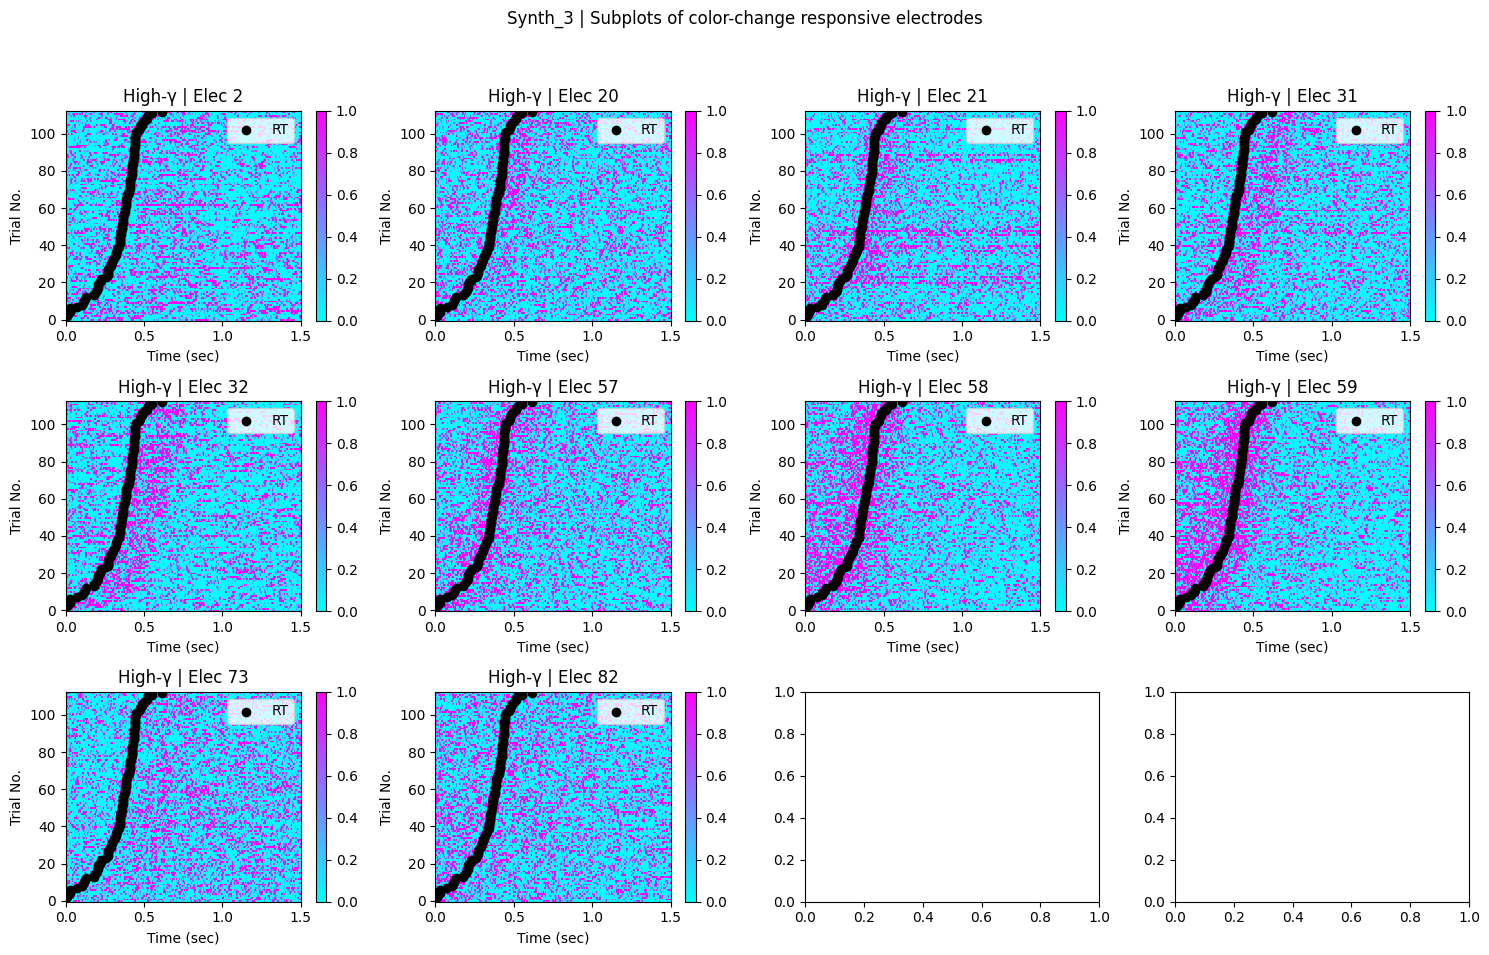

In [5]:
# Import an example subject
part = 'Synth_3' 
with open(os.getcwd() + f'/participants_fdr/{part}', 'rb') as handle:
    subject = pickle.load(handle)

time_task = (0, 1.5)  # This is the time interval after the color-change that will be considered the task period
idx_task = np.flatnonzero(np.logical_and(subject.timestamps_sec > min(time_task), subject.timestamps_sec < max(time_task)))
respRT = subject.beh_df['RT'].to_numpy()    
order = np.argsort(respRT)  # From fastest to slowest
envelope_sorted = subject.envelope[order, :, :, :]
respRT_sorted = respRT[order]
significant_locs = [i for i, x in enumerate(subject.task_related_locations_prob_fdr_significant) if x]

# Create subplots grid
n_rows = 3  # Adjust based on how many plots you want per row
n_cols = len(significant_locs) // n_rows + (len(significant_locs) % n_rows > 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust the figure size if needed

# Flatten axs in case it's a 2D array
axs = axs.flatten()

for j, i in enumerate(significant_locs):
    # Colormap plot
    x = envelope_sorted[:, :, :, -1]  # Keep f-band of interest
    x = x[:, idx_task, :]
    t = subject.timestamps_sec[idx_task]  # Save the timestamps of the task
    pcm = axs[j].pcolor(t, np.arange(x.shape[0]), x[:, :, i], vmin=0, vmax=1, cmap='cool')
    axs[j].set(ylabel='Trial No.', xlabel='Time (sec)', title=f'High-γ | Elec {i}')
    fig.colorbar(pcm, ax=axs[j])

    axs[j].scatter((respRT_sorted) / 1000, np.arange(len(order)), label='RT', color='k')
    axs[j].set_xlim(left=0, right=1.5)
    axs[j].legend()

    # Add subplot title and labels
    # axs[j].set_title(f'Elec {i} | isWM={subject.anatDfThisSubj.isWM[i]} | ROI={subject.anatDfThisSubj.roi[i]}')

plt.suptitle(f'{part} | Subplots of color-change responsive electrodes')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for suptitle
plt.show()

# plt.show()
# plt.close()


### Let's make a pytorch dataset with the sEEG activity of the responsive electrodes.

Now that we have identified electrodes whose high-gamma band activity is modulated by the stimulus color change, we will use their neural activity to infer the response time for each trial.

In [6]:
import torch
from torch.utils.data import Dataset
import os
from Model_and_Training.sEEGDataset import ParticipantDataset

First, we build a dataset with the combined data of all our subjects. The dataset contains the following information for each trial of each subject (and returns it when using __getitem__):
1. subj_id: torch.Tensor(). A numerical ID (int) associated with each subject. 
2. data: torch.Tensor(1, electrodes, timepoints). A tensor of the combined sEEG activity associated with a behavioral trial. 
3. mni_coords: torch.Tensor(electrodes, 3). The MNI coordinates -- x, y, z -- triplet for each electrode.
4. targets: torch.Tensor(1). The response time associated with a trial.
5. bintargets: torch.Tensor(1). The binarized response time for each trials (whether the response time for a trial was fast or slow). 


In [7]:
# Make the dataset
dat = ParticipantDataset(['Synth_' + x for x in ['1', '2', '3']], os.getcwd() + f'/participants_fdr/')
# Save the dataset
torch.save(dat, os.getcwd() + '/data/dataset.pt')
# Ensure that you can load the dataset
dat = torch.load(os.getcwd() + '/data/dataset.pt')

/tmp/ipykernel_14041/3223268895.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dat = torch.load(os.getcwd() + '/data/dataset.pt')


### Let's train some models


In [8]:
import os
import torch.optim.lr_scheduler
import time
import wandb
from Model_and_Training.model import seegnificant
from Model_and_Training.utils import train, evaluate, reset_weights
os.environ["WANDB_SILENT"] = "true"
import itertools


### First, we will train a single-subject model on the data of Synth_1 only.

In [9]:
training_hparams = dict(
    seed=0,  # This is the seed for the data split
    epochs=1000,  # Total number of training epochs
    batch_size=64,  
    train_frac=0.7,  # Proportion of data used for training 
    val_frac=0.15,  # Proportion of data used for validation
    test_frac=0.15,  # Proportion of data used for testing
    num_participants=3, # This is the TOTAL number of participants in our cohort [not just those used for training of single subject models] - used to initialize separate regression heads for each subject.
    lr=0.001,  # Learning rate for optimizer
    b1=0.5,  # Parameter of optimizer
    b2=0.999,  # Parameter of optimizer
    gamma=0.5,  # Parameter of lr scheduler
    step_size=200,  # Number of epochs required for the learning rate to decrease.
)

model_hparams = dict(
    latent_dim=2,  # Number of convolutional kernels
    num_blocks=1,  # Number of sequential attention in time and attention in space blocks
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
torch.manual_seed(0)  # Fix the torch seed.

In [10]:
name = 'Synth_1' # Here we specify the name of the participant on whose data we are going to train the single-subject models.

In [11]:
config = {**training_hparams, **model_hparams}

run = wandb.init(project="Seegnificant", config=config, name=name)

config = wandb.config

g = torch.Generator().manual_seed(config.seed)

# Load the dataset and split into training/validation/testing
dataset = torch.load(os.getcwd() + '/data/dataset.pt')
training_data, validation_data, testing_data = torch.utils.data.random_split(dataset, [config.train_frac,  config.val_frac, config.test_frac], generator=g)

# Keep data from only the participant you want to train the single subject model on (specified as name in the previous block)
training_data.indices = list(itertools.compress(training_data.indices, training_data.dataset.id[training_data.indices] == training_data.dataset.participants.index(name)))
validation_data.indices = list(itertools.compress(validation_data.indices, validation_data.dataset.id[validation_data.indices] == validation_data.dataset.participants.index(name)))
testing_data.indices = list(itertools.compress(testing_data.indices, testing_data.dataset.id[testing_data.indices] == testing_data.dataset.participants.index(name)))

# Check that there is no overlap between training/validation/testing sets
assert set(training_data.indices).intersection(validation_data.indices) == set()
assert set(training_data.indices).intersection(testing_data.indices) == set()
assert set(validation_data.indices).intersection(testing_data.indices) == set()

# Form the dataloaders
trainloader = torch.utils.data.DataLoader(training_data, batch_size=config.batch_size, shuffle=True, generator=g)
validloader = torch.utils.data.DataLoader(validation_data, batch_size=config.batch_size, shuffle=True, generator=g)
testloader = torch.utils.data.DataLoader(testing_data, batch_size=config.batch_size, shuffle=True, generator=g)

# Initialize the models
model = seegnificant(config.latent_dim, config.num_blocks, config.num_participants).to(device)
reset_weights(model)  # Reset the weights just in case there is some weight leakage from a previous run

# Initialize the optimizer and the Loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], betas=(config['b1'], config['b2']))
criterion_reg = torch.nn.HuberLoss()  # nn.MSELoss()

# Initialize the learning rate scheduler 
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=config.step_size, gamma=config.gamma)

/tmp/ipykernel_14041/4198840361.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(os.getcwd() + '/data/dataset.pt')


This is the training loop. We evaluate our network every 10 training epochs and save the model that achieved the lowest validation loss for testing.

In [12]:
best_val_loss_reg = None
val_loss_reg = None
trainLossHist = []
trainR2Hist = []
validLossHist = []
validR2Hist = []

# Train the network. At any point press cntl+C to stop the training early
try:
    for epoch in range(1, config.epochs + 1):
        epoch_start_time = time.time()
        model, train_loss_reg, train_r2 = train(model, trainloader, optimizer, criterion_reg, epoch, device)
        trainLossHist.append([epoch, train_loss_reg])
        trainR2Hist.append([epoch, train_r2])
        lr_scheduler.step()
        print('| Epoch {:3d} | time: {:5.2f}s | Train | Loss {:5.5f} | R2 {:1.2f} '.format(
            epoch, (time.time() - epoch_start_time), train_loss_reg, train_r2))
    
        if epoch % 10 == 0:
            epoch_start_time = time.time()
            val_loss_reg, valid_r2 = evaluate(model, validloader, criterion_reg, epoch, device)
            validLossHist.append([epoch, val_loss_reg])
            validR2Hist.append([epoch, valid_r2])
    
            if not best_val_loss_reg or val_loss_reg < best_val_loss_reg:
                torch.save(model.state_dict(), f'./models/SingleSubjectModelReg{name}')
                best_val_loss_reg = val_loss_reg
            print('-' * 97)
            print('| Epoch {:3d} | time: {:5.2f}s | Valid | Loss {:5.5f} | R2 {:1.2f}'.format(
                epoch, (time.time() - epoch_start_time), val_loss_reg, valid_r2))
            print('-' * 97)
except KeyboardInterrupt:
    pass

# Evaluate the "best" regression model
checkpoint = torch.load(f'./models/SingleSubjectModelReg{name}', weights_only=True)
model.load_state_dict(checkpoint)

val_loss_reg, valid_r2 = evaluate(model, validloader, criterion_reg, epoch, device)
test_loss_reg, test_r2 = evaluate(model, testloader, criterion_reg, epoch, device)
print('=' * 97)
print('| End of training | ValLoss {:5.5f} | ValR2{:1.2f} | TestLoss {:5.5f} | TestR2 {:1.2f}'.format(
    val_loss_reg, valid_r2, test_loss_reg, test_r2))
print('=' * 97)
# Close wandb
run.finish()

| Epoch   1 | time:  1.20s | Train | Loss 0.06049 | R2 -15.55 
| Epoch   2 | time:  0.82s | Train | Loss 0.13413 | R2 -37.59 
| Epoch   3 | time:  0.64s | Train | Loss 0.09825 | R2 -25.89 
| Epoch   4 | time:  0.64s | Train | Loss 0.08242 | R2 -21.56 
| Epoch   5 | time:  0.64s | Train | Loss 0.03356 | R2 -8.19 
| Epoch   6 | time:  0.66s | Train | Loss 0.05077 | R2 -12.90 
| Epoch   7 | time:  0.64s | Train | Loss 0.03727 | R2 -9.20 
| Epoch   8 | time:  0.64s | Train | Loss 0.04005 | R2 -9.96 
| Epoch   9 | time:  0.64s | Train | Loss 0.03967 | R2 -9.86 
| Epoch  10 | time:  0.64s | Train | Loss 0.03354 | R2 -8.18 
-------------------------------------------------------------------------------------------------
| Epoch  10 | time:  0.11s | Valid | Loss 0.01986 | R2 -4.17
-------------------------------------------------------------------------------------------------
| Epoch  11 | time:  0.64s | Train | Loss 0.02025 | R2 -4.54 
| Epoch  12 | time:  0.65s | Train | Loss 0.03656 | R2 -

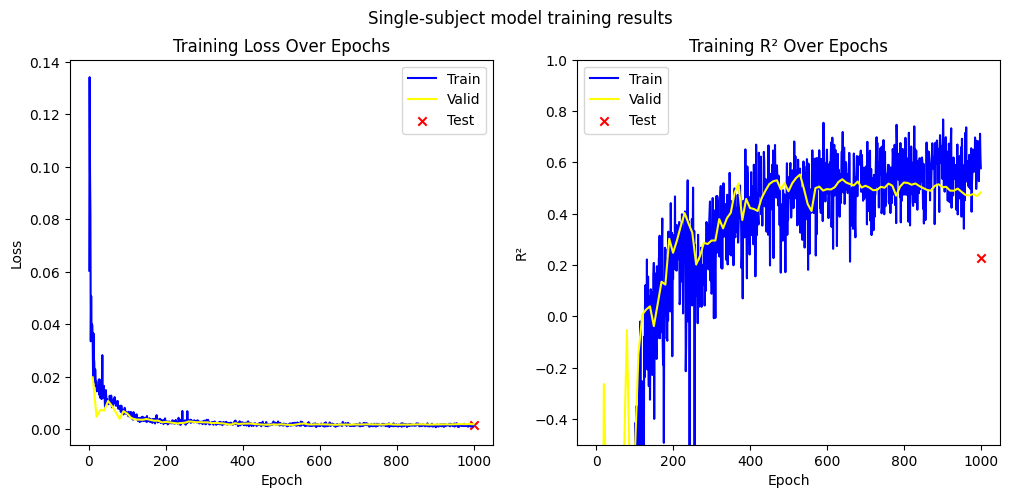

In [13]:
# After training, plot the loss and R² history
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in trainLossHist], [x[1].detach().cpu() for x in trainLossHist], label='Train', color='blue')
plt.plot([x[0] for x in validLossHist], [x[1].detach().cpu() for x in validLossHist], label='Valid', color='yellow')
plt.scatter([x[0] for x in validLossHist][-1], test_loss_reg.detach().cpu(), label='Test', marker = 'x', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot([x[0] for x in trainR2Hist], [x[1].detach().cpu() for x in trainR2Hist], label='Train', color='blue')
plt.plot([x[0] for x in validR2Hist], [x[1].detach().cpu() for x in validR2Hist], label='Valid', color='yellow')
plt.scatter([x[0] for x in validR2Hist][-1], test_r2.detach().cpu(), label='Test', marker = 'x', color='red')
plt.ylim([-0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training R² Over Epochs')
plt.legend()

plt.suptitle('Single-subject model training results')

# Show the plots
plt.show()

### Now let's train a model on the combined data of multiple subjects. 
We will train a multi-subject model on the combined data of subjects: Synth_1 and Synth_3. 
We will keep the data of subject Synth_2 out of training to demonstrate the model's transfer capabilities in a later section.

In [14]:
training_hparams = dict(
    seed=0,  # This is the seed for the data split
    epochs=1000,
    batch_size=128,
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    num_participants=3, # This is the total number of participants in our cohort [not just those used for training].
    lr=0.001,
    b1=0.5,
    b2=0.999,
    gamma=0.9,
    step_size=100,
)
model_hparams = dict(
    latent_dim=2,
    num_blocks=1,
)

config = {**training_hparams, **model_hparams}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

In [15]:
name_of_left_out_participant = 'Synth_1'  # Specify the name of the subject that you want to be left out during training.

In [16]:
wandb.login()
config = {**training_hparams, **model_hparams}
run = wandb.init(project="Seegnificant", config=config, name='Train_Backbone_' + name_of_left_out_participant)

config = wandb.config

g = torch.Generator().manual_seed(config.seed)

# Load the dataset and split into training and validation
dataset = torch.load(os.getcwd() + '/data/dataset.pt')
training_data, validation_data, testing_data = torch.utils.data.random_split(dataset, [config.train_frac,  config.val_frac, config.test_frac], generator=g)

# Keep data from all participants but the Left out Participant
training_data.indices = list(itertools.compress(training_data.indices, training_data.dataset.id[training_data.indices] != training_data.dataset.participants.index(name_of_left_out_participant)))
validation_data.indices = list(itertools.compress(validation_data.indices, validation_data.dataset.id[validation_data.indices] != validation_data.dataset.participants.index(name_of_left_out_participant)))
testing_data.indices = list(itertools.compress(testing_data.indices, testing_data.dataset.id[testing_data.indices] != testing_data.dataset.participants.index(name_of_left_out_participant)))

# Check that there is no overlap between training/validation/testing
assert set(training_data.indices).intersection(validation_data.indices) == set()
assert set(training_data.indices).intersection(testing_data.indices) == set()
assert set(validation_data.indices).intersection(testing_data.indices) == set()

# Form the dataloaders
trainloader = torch.utils.data.DataLoader(training_data, batch_size=config.batch_size, shuffle=True, generator=g)
validloader = torch.utils.data.DataLoader(validation_data, batch_size=config.batch_size, shuffle=True, generator=g)
testloader = torch.utils.data.DataLoader(testing_data, batch_size=config.batch_size, shuffle=True, generator=g)

# Initialize the models
model = seegnificant(config.latent_dim, config.num_blocks, config.num_participants).to(device)
reset_weights(model)  # Reset the weights to ensure there is no weight leakage from previous runs.

# Initialize the optimizer and Loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], betas=(config['b1'], config['b2']))
criterion_reg = torch.nn.HuberLoss()

# Initialize the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=config.step_size, gamma=config.gamma)

/tmp/ipykernel_14041/4152631051.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(os.getcwd() + '/data/dataset.pt')


In [17]:
best_val_loss_reg = None
val_loss_reg = None
trainLossHist = []
trainR2Hist = []
validLossHist = []
validR2Hist = []

# Train the network. At any point press cntl+C to stop the training early
try:
    for epoch in range(1, config.epochs + 1):
        epoch_start_time = time.time()
        model, train_loss_reg, train_r2 = train(model, trainloader, optimizer, criterion_reg, epoch, device)
        trainLossHist.append([epoch, train_loss_reg])
        trainR2Hist.append([epoch, train_r2])
        lr_scheduler.step()
        print('| Epoch {:3d} | time: {:5.2f}s | Train | Loss {:5.5f} | R2 {:1.2f} '.format(
            epoch, (time.time() - epoch_start_time), train_loss_reg, train_r2))
    
        if epoch % 10 == 0:
            epoch_start_time = time.time()
            val_loss_reg, valid_r2 = evaluate(model, validloader, criterion_reg, epoch, device)
            validLossHist.append([epoch, val_loss_reg])
            validR2Hist.append([epoch, valid_r2])
    
            if not best_val_loss_reg or val_loss_reg < best_val_loss_reg:
                torch.save(model.state_dict(), f'./models/MultiSubjectModelRegWithout{name_of_left_out_participant}')
                best_val_loss_reg = val_loss_reg
            print('-' * 97)
            print('| Epoch {:3d} | time: {:5.2f}s | Valid | Loss {:5.5f} | R2 {:1.2f}'.format(
                epoch, (time.time() - epoch_start_time), val_loss_reg, valid_r2))
            print('-' * 97)
except KeyboardInterrupt:
    pass

# Evaluate the "best" regression model
checkpoint = torch.load(f'./models/MultiSubjectModelRegWithout{name_of_left_out_participant}', weights_only=True)
model.load_state_dict(checkpoint)

val_loss_reg, valid_r2 = evaluate(model, validloader, criterion_reg, epoch, device)
test_loss_reg, test_r2 = evaluate(model, testloader, criterion_reg, epoch, device)

print('=' * 97)
print('| End of training | ValLoss {:5.5f} | ValR2{:1.2f} | TestLoss {:5.5f} | TestR2 {:1.2f}'.format(
    val_loss_reg, valid_r2, test_loss_reg, test_r2))
print('=' * 97)
# Close wandb
run.finish()

| Epoch   1 | time:  1.81s | Train | Loss 0.06558 | R2 -7.52 
| Epoch   2 | time:  1.81s | Train | Loss 0.07291 | R2 -8.33 
| Epoch   3 | time:  1.81s | Train | Loss 0.06092 | R2 -6.75 
| Epoch   4 | time:  1.81s | Train | Loss 0.05086 | R2 -5.49 
| Epoch   5 | time:  1.81s | Train | Loss 0.03019 | R2 -2.84 
| Epoch   6 | time:  1.81s | Train | Loss 0.03157 | R2 -3.02 
| Epoch   7 | time:  1.82s | Train | Loss 0.02387 | R2 -2.04 
| Epoch   8 | time:  1.81s | Train | Loss 0.02293 | R2 -1.92 
| Epoch   9 | time:  1.81s | Train | Loss 0.02208 | R2 -1.81 
| Epoch  10 | time:  1.81s | Train | Loss 0.01921 | R2 -1.45 
-------------------------------------------------------------------------------------------------
| Epoch  10 | time:  0.26s | Valid | Loss 0.01035 | R2 -0.68
-------------------------------------------------------------------------------------------------
| Epoch  11 | time:  1.81s | Train | Loss 0.01440 | R2 -0.83 
| Epoch  12 | time:  1.82s | Train | Loss 0.01282 | R2 -0.63 

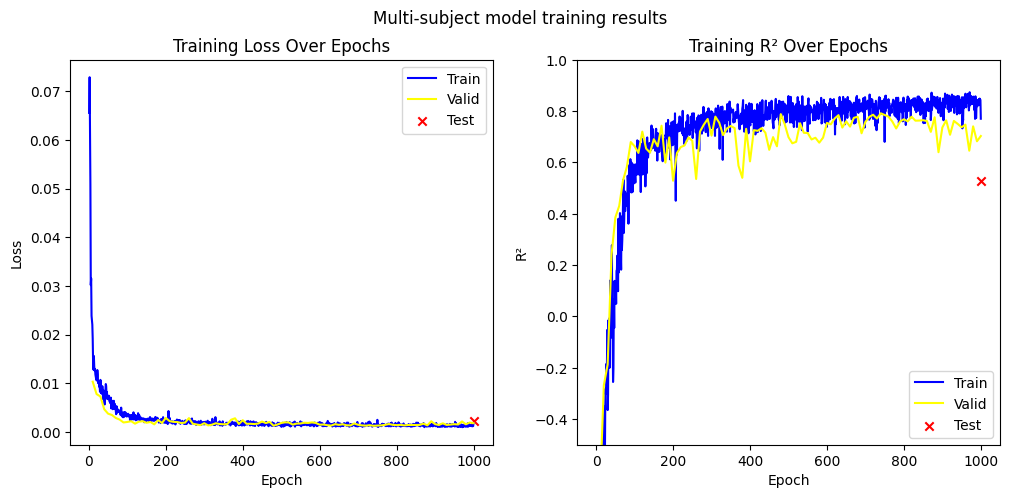

In [18]:
# After training, plot the loss and R² history
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in trainLossHist], [x[1].detach().cpu() for x in trainLossHist], label='Train', color='blue')
plt.plot([x[0] for x in validLossHist], [x[1].detach().cpu() for x in validLossHist], label='Valid', color='yellow')
plt.scatter([x[0] for x in validLossHist][-1], test_loss_reg.detach().cpu(), label='Test', marker = 'x', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot([x[0] for x in trainR2Hist], [x[1].detach().cpu() for x in trainR2Hist], label='Train', color='blue')
plt.plot([x[0] for x in validR2Hist], [x[1].detach().cpu() for x in validR2Hist], label='Valid', color='yellow')
plt.scatter([x[0] for x in validR2Hist][-1], test_r2.detach().cpu(), label='Test', marker = 'x', color='red')
plt.ylim([-0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training R² Over Epochs')
plt.legend()

plt.suptitle('Multi-subject model training results')

# Show the plots
plt.show()

Note that the R² score reported in the plot above is calculated over the combined data of all subjects. Therefore, it cannot be directly compared with the single-subject obtained R² scores.

### Now let's transfer the multi-subject model to the left-out subject.
 To do this, we will use the weights of the multi-subject model as a basis of finetune for training a model on the data of the left-out participant.
 The left-out participant has a completely untrained regression head as well, which will be trained from scratch. 

In [19]:
name = 'Synth_1'  # Name of the left-out participant during multi-subject training

In [20]:
training_hparams = dict(
    seed=0,  # This is the seed for the data split
    epochs=1000,  # Total number of training epochs
    batch_size=64,  
    train_frac=0.7,  # Proportion of data used for training 
    val_frac=0.15,  # Proportion of data used for validation
    test_frac=0.15,  # Proportion of data used for testing
    num_participants=3, # This is the TOTAL number of participants in our cohort [not just those used for training of single subject models] - used to initialize separate regression heads for each subject.
    lr=0.001,  # Learning rate for optimizer
    b1=0.5,  # Parameter of optimizer
    b2=0.999,  # Parameter of optimizer
    gamma=0.5,  # Parameter of lr scheduler
    step_size=200,  # Number of epochs required for the learning rate to decrease.
    weights_path=f'./models/MultiSubjectModelRegWithout{name}'
)

model_hparams = dict(
    latent_dim=2,  # Number of convolutional kernels
    num_blocks=1,  # Number of sequential attention in time and attention in space blocks
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
torch.manual_seed(0)  # Fix the torch seed.
config = {**training_hparams, **model_hparams}

In [21]:
run = wandb.init(project="Seegnificant", config=config, name=name)

config = wandb.config

g = torch.Generator().manual_seed(config.seed)

# Load the dataset and split into training and validation
dataset = torch.load(os.getcwd() + '/data/dataset.pt')
training_data, validation_data, testing_data = torch.utils.data.random_split(dataset, [config.train_frac,  config.val_frac, config.test_frac], generator=g)

# Keep data from the left-out participant only
training_data.indices = list(itertools.compress(training_data.indices, training_data.dataset.id[training_data.indices] == training_data.dataset.participants.index(name)))
validation_data.indices = list(itertools.compress(validation_data.indices, validation_data.dataset.id[validation_data.indices] == validation_data.dataset.participants.index(name)))
testing_data.indices = list(itertools.compress(testing_data.indices, testing_data.dataset.id[testing_data.indices] == testing_data.dataset.participants.index(name)))

# Check that there is no overlap between training/validation/testing
assert set(training_data.indices).intersection(validation_data.indices) == set()
assert set(training_data.indices).intersection(testing_data.indices) == set()
assert set(validation_data.indices).intersection(testing_data.indices) == set()

# Form the dataloaders
trainloader = torch.utils.data.DataLoader(training_data, batch_size=config.batch_size, shuffle=True, generator=g)
validloader = torch.utils.data.DataLoader(validation_data, batch_size=config.batch_size, shuffle=True, generator=g)
testloader = torch.utils.data.DataLoader(testing_data, batch_size=config.batch_size, shuffle=True, generator=g)

# Initialize the models
model = seegnificant(config.latent_dim, config.num_blocks, config.num_participants).to(device)

# Import the weights of the pretrained - multi-subject model.
checkpoint = torch.load(config.weights_path, weights_only=True)
model.load_state_dict(checkpoint)

# Initialize the optimizer.
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], betas=(config['b1'], config['b2']))
criterion_reg = torch.nn.HuberLoss()  # nn.MSELoss()

# Initialize the learning rate scheduler.
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=config.step_size, gamma=config.gamma)

/tmp/ipykernel_14041/2234817265.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(os.getcwd() + '/data/dataset.pt')


This is the training loop.

Contrary to single subject models trained from scratch, this model comes with a pre-trained backbone. To take advantage of this, we will unfreeze the model weights asyncronously.
For the first 400 epochs, we will keep the weights of the backbone frozen - and will only train the regression head of the left-out subject.
For the remaining epochs, we will unfreeze all the model weights and train all the weights of the network. 

In [22]:
# Freeze the backbone & only allow the heads to train
for param in model.parameters():
   param.requires_grad = False
for param in model.taskHeads.parameters():
   param.requires_grad = True
   
best_val_loss_reg = None
val_loss_reg = None
trainLossHist = []
trainR2Hist = []
validLossHist = []
validR2Hist = []


# Train the network. At any point press cntl+C to stop the training early
try:
    for epoch in range(1, config.epochs + 1):
        
        # Unfreeze the whole network
        if epoch == 400:
           for param in model.parameters():
               param.requires_grad = True
                
        epoch_start_time = time.time()
        model, train_loss_reg, train_r2 = train(model, trainloader, optimizer, criterion_reg, epoch, device)
        trainLossHist.append([epoch, train_loss_reg])
        trainR2Hist.append([epoch, train_r2])
        lr_scheduler.step()
        print('| Epoch {:3d} | time: {:5.2f}s | Train | Loss {:5.5f} | R2 {:1.2f} '.format(
            epoch, (time.time() - epoch_start_time), train_loss_reg, train_r2))
    
        if epoch % 10 == 0:
            epoch_start_time = time.time()
            val_loss_reg, valid_r2 = evaluate(model, validloader, criterion_reg, epoch, device)
            validLossHist.append([epoch, val_loss_reg])
            validR2Hist.append([epoch, valid_r2])
    
            if not best_val_loss_reg or val_loss_reg < best_val_loss_reg:
                torch.save(model.state_dict(), f'./models/TransferredModelReg{name}')
                best_val_loss_reg = val_loss_reg
            print('-' * 97)
            print('| Epoch {:3d} | time: {:5.2f}s | Valid | Loss {:5.5f} | R2 {:1.2f}'.format(
                epoch, (time.time() - epoch_start_time), val_loss_reg, valid_r2))
            print('-' * 97)
except KeyboardInterrupt:
    pass

# Evaluate the "best" regression model
checkpoint = torch.load(f'./models/TransferredModelReg{name}', weights_only=True)
model.load_state_dict(checkpoint)

val_loss_reg, valid_r2 = evaluate(model, validloader, criterion_reg, epoch, device)
test_loss_reg, test_r2 = evaluate(model, testloader, criterion_reg, epoch, device)

print('=' * 97)
print('| End of training | ValLoss {:5.5f} | ValR2{:1.2f} | TestLoss {:5.5f} | TestR2 {:1.2f}'.format(
    val_loss_reg, valid_r2, test_loss_reg, test_r2))
print('=' * 97)
# Close wandb
run.finish()

| Epoch   1 | time:  0.41s | Train | Loss 0.05198 | R2 -13.22 
| Epoch   2 | time:  0.41s | Train | Loss 0.03937 | R2 -9.77 
| Epoch   3 | time:  0.41s | Train | Loss 0.04590 | R2 -11.56 
| Epoch   4 | time:  0.41s | Train | Loss 0.04465 | R2 -11.22 
| Epoch   5 | time:  0.41s | Train | Loss 0.04656 | R2 -11.74 
| Epoch   6 | time:  0.41s | Train | Loss 0.04328 | R2 -10.84 
| Epoch   7 | time:  0.41s | Train | Loss 0.03734 | R2 -9.22 
| Epoch   8 | time:  0.41s | Train | Loss 0.02799 | R2 -6.66 
| Epoch   9 | time:  0.41s | Train | Loss 0.03164 | R2 -7.66 
| Epoch  10 | time:  0.41s | Train | Loss 0.02885 | R2 -6.90 
-------------------------------------------------------------------------------------------------
| Epoch  10 | time:  0.09s | Valid | Loss 0.01515 | R2 -2.95
-------------------------------------------------------------------------------------------------
| Epoch  11 | time:  0.41s | Train | Loss 0.03638 | R2 -8.96 
| Epoch  12 | time:  0.41s | Train | Loss 0.02561 | R2 -

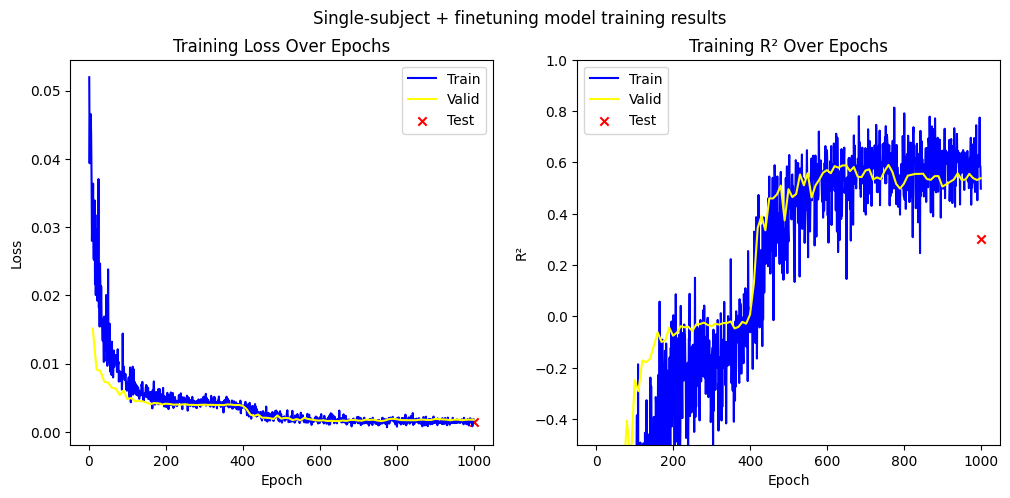

In [23]:
# After training, plot the loss and R² history
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in trainLossHist], [x[1].detach().cpu() for x in trainLossHist], label='Train', color='blue')
plt.plot([x[0] for x in validLossHist], [x[1].detach().cpu() for x in validLossHist], label='Valid', color='yellow')
plt.scatter([x[0] for x in validLossHist][-1], test_loss_reg.detach().cpu(), label='Test', marker = 'x', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot([x[0] for x in trainR2Hist], [x[1].detach().cpu() for x in trainR2Hist], label='Train', color='blue')
plt.plot([x[0] for x in validR2Hist], [x[1].detach().cpu() for x in validR2Hist], label='Valid', color='yellow')
plt.scatter([x[0] for x in validR2Hist][-1], test_r2.detach().cpu(), label='Test', marker = 'x', color='red')
plt.ylim([-0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training R² Over Epochs')
plt.legend()

plt.suptitle('Single-subject + finetuning model training results')

# Show the plots
plt.show()